# Lightgbm

In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

import lightgbm

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler

from IPython.display import display

from utils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load possible outliers (Optional)

In [3]:
outliers_idx = np.load('isolation_forest_outliers.npy', mmap_mode='r')
outliers_idx = np.array(outliers_idx)

### Load data

In [3]:
train = pd.read_csv('input/train.csv')
print(train.shape)

(307511, 199)


In [16]:
#display(train.head(2))

In [4]:
test = pd.read_csv('input/test.csv')
print(test.shape)

(48744, 198)


Outliers removal (optional step)

In [ ]:
train = train.drop(index=train.index[outliers_idx])
train = train.reset_index(drop=True)

Removing service and target columns

In [5]:
targets = train[['TARGET']]

train_ids = train['SK_ID_CURR']
train = train.drop(columns=['SK_ID_CURR', 'TARGET'])

In [6]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

In [17]:
targets.shape

(307511, 1)

### Drop redundant columns
Columns which almost identical (correlation is close to 1)

In [8]:
cols_drop = appartment_mode_cols + appartment_medi_cols
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)

In [9]:
print(train.shape)
print(test.shape)

(307511, 177)
(48744, 177)


### List Categorical Features

In [10]:
cat_features = train.select_dtypes('object').columns.tolist()

In [11]:
for col in cat_features: 
    train[col] = train[col].astype('category') 
    test[col] = test[col].astype('category') 

### Parameter Tuning

In [30]:
best_params = {
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 10000,
    'num_leaves': 32,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5
}

params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [8000, 16000],
    'num_leaves': [16, 32],
    'max_depth': [-1, 4, 7],
    'min_child_samples': [10, 20, 40],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'max_bin': [127, 255]
}

# rscv = RandomizedSearchCV(model, params, n_iter=20, cv=5, n_jobs=1, verbose=1)
# rscv.fit(train, targets[['TARGET']], categorical_feature=cat_features,
#          eval_metric='auc', verbose=100)
cv_results = []

for i, param_smple in enumerate(list(ParameterSampler(params, 20))):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []
    train_scores = []
    params_ = dict(param_smple)
    params_['params'] = param_smple
    start = time.time()
    fold_i = 0
    for train_indices, valid_indices in k_fold.split(train, targets):
        train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
        valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
        test_features = test
        model = lightgbm.LGBMClassifier(n_estimators=param_smple['n_estimators'], objective='binary', 
                                    class_weight='balanced', learning_rate=param_smple['learning_rate'], 
                                    num_leaves=param_smple['num_leaves'], max_depth=param_smple['max_depth'],
                                    reg_alpha=param_smple['reg_alpha'], reg_lambda=param_smple['reg_lambda'], 
                                    min_child_samples=param_smple['min_child_samples'],
                                    subsample=0.8, n_jobs=6, random_state=4242, max_bin=param_smple['max_bin'])
    
        model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                      eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                      eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        params_['train_score_%s' % fold_i] = model.best_score_['train']['auc']
        params_['valid_score_%s' % fold_i] = model.best_score_['valid']['auc']
        fold_i += 1
    
    end = time.time()
    params_['fit_time'] = end - start
    params_['mean_train_score'] = np.mean(train_scores)
    params_['mean_valid_score'] = np.mean(valid_scores)
    cv_results.append(params_)
    

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.749424	valid's auc: 0.733532
Did not meet early stopping. Best iteration is:
[160]	train's auc: 0.761489	valid's auc: 0.742569
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.749747	valid's auc: 0.737687
Did not meet early stopping. Best iteration is:
[160]	train's auc: 0.761263	valid's auc: 0.746477
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.749747	valid's auc: 0.73799
Did not meet early stopping. Best iteration is:
[160]	train's auc: 0.760758	valid's auc: 0.746349
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.749609	valid's auc: 0.737701
Did not meet early stopping. Best iteration is:
[160]	train's auc: 0.760712	valid's auc: 0.745379
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.748766	valid's auc: 0.738204
Did not meet early stopping. Best iteration 

In [31]:
df_results = pd.DataFrame(cv_results)
df_results

,fit_time,learning_rate,max_bin,max_depth,mean_train_score,mean_valid_score,min_child_samples,n_estimators,num_leaves,params,reg_alpha,reg_lambda,train_score_0,train_score_1,train_score_2,train_score_3,train_score_4,valid_score_0,valid_score_1,valid_score_2,valid_score_3,valid_score_4
0,87.152045,0.01,127,-1,0.760919,0.745473,40,160,32,"{'reg_alpha': 0.5, 'reg_lambda': 1.0, 'num_lea...",0.5,1.0,0.761489,0.761263,0.760758,0.760712,0.760371,0.742569,0.746477,0.746349,0.745379,0.746593
1,68.238248,0.10,255,-1,0.814306,0.774570,40,160,16,"{'reg_alpha': 0.1, 'reg_lambda': 0.1, 'num_lea...",0.1,0.1,0.814303,0.814186,0.814375,0.814646,0.814021,0.773081,0.775153,0.774863,0.773559,0.776197


In [32]:
best_index = df_results.mean_valid_score.idxmax()
df_results.iloc[best_index]['params']

{'learning_rate': 0.1,
 'max_bin': 255,
 'max_depth': -1,
 'min_child_samples': 40,
 'n_estimators': 160,
 'num_leaves': 16,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1}

### Model K-Fold Execution

In [14]:
features = np.array(train)
test_features = np.array(test)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

valid_scores = []
train_scores = []
test_predictions = np.zeros(test_features.shape[0])

for train_indices, valid_indices in k_fold.split(features, targets):
    # Numpy version
    # Training data for the fold
    #train_features, train_labels = features[train_indices], targets[train_indices]
    # Validation data for the fold
    #valid_features, valid_labels = features[valid_indices], targets[valid_indices]
    
    # DataFrame version
    train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
    valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    test_features = test
    
    # d_train = lightgbm.Dataset(train_features, label=train_labels)
    # d_valid = lightgbm.Dataset(valid_features, label=valid_labels)
    # model = lightgbm.train(parameters, d_train, verbose_eval=100, valid_sets=[d_valid], num_boost_round=20000, early_stopping_rounds=200)
    
    # The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional
    # to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    model = lightgbm.LGBMClassifier(n_estimators=10000, objective='binary', 
                                    class_weight='balanced', learning_rate=0.0003, 
                                    num_leaves=31, max_depth=-1,
                                    reg_alpha=3, reg_lambda=5, 
                                    subsample=0.8, n_jobs=6, random_state=4242)
    
    model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

    best_iteration = model.best_iteration_
    
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)


KeyError: '[     0      1      2 ... 307507 307508 307509] not in index'

### Plots

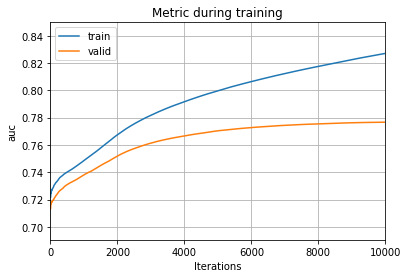

In [28]:
lightgbm.plot_metric(model)

In [ ]:
lightgbm.plot_tree(model)

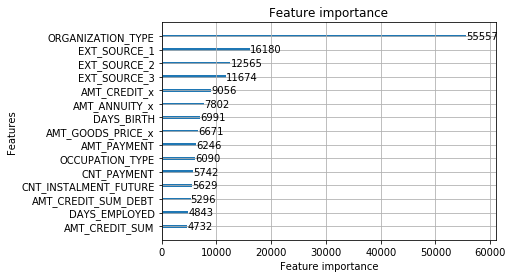

In [33]:
lightgbm.plot_importance(model, max_num_features=15)

In [44]:
model.booster_

### Submission

In [35]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
save_prediction(submission, 'lightgbm')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-lightgbm.csv -m "lightgbm"'